# Interactive apps with Panel

This notebook serves as a tutorial on building interactive apps for MNE-based analysis using the Panel framework.

 * You will learn the basic workflow of Panel apps
 * You will practice adding widgets to the Panel app in a toy example first
 * Then, you will map several widgets to explore the parameters of Welch and multitaper methods for estimation of power spectral density (PSD) in MNE-Python

`Author: Nikolai Kapralov`

In [1]:
import mne
import matplotlib.pyplot as plt
import panel as pn

from mne_bids import print_dir_tree
from pathlib import Path

pn.extension(sizing_mode='stretch_width',
             theme='default')

C:\Users\wmvan\mambaforge\lib\site-packages\mne_bids\utils.py:19: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types
C:\Users\wmvan\mambaforge\lib\site-packages\mne_bids\read.py:20: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_channels_regexp
C:\Users\wmvan\mambaforge\lib\site-packages\mne_bids\write.py:28: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import channel_type, _picks_to_idx


### Interactivity and Widgets

Source: https://panel.holoviz.org/how_to/interactivity/index.html

For the minimal example, we can use a function that creates a string by repeating a provided symbol given number of times. We will bind its arguments to UI widgets and make the function interactive!

In [2]:
def string_creator(symbol, number):
    return symbol * number

In [3]:
string_creator('🌊', 5)

'🌊🌊🌊🌊🌊'

Now we need to create two widgets corresponding to the arguments of the function. Overall, there are lots of different widgets ([listed here](https://panel.holoviz.org/reference/index.html#widgets)), and often there are multiple options to choose from depending on the context. Here and in the next examples, we will use select/drop-down for choosing between several _textual_ options and slider for setting the _numeric_ values.

The core parameter of many widgets is `value`, which contains the current value and also allows setting the initial one. Other parameters may include display name (`name`) or widget-specific input constraints (e.g., `start` and `end` for the slider range or `options` to select from).

Below are the widgets that are helpful for this minimal example:

In [4]:
slider = pn.widgets.IntSlider(name='Length', value=5, start=1, end=10)
slider

IntSlider(end=10, name='Length', sizing_mode='stretch_width', start=1, value=5)

Change the position of slider and re-run the cell below to see the updated value:

In [5]:
slider.value

5

In [6]:
select = pn.widgets.Select(name='Symbol', options=['🌊', '🐘'])
select

Select(name='Symbol', options=['🌊', '🐘'], sizing_mode='stretch_width', value='🌊')

In [7]:
select.value

'🌊'

The next essential step is to combine (bind) together the input values from the widgets with the function that generates the output. The function `bind` serve for this purpose.

It accepts the function as the first argument and several objects that will be provided to this function (the number of provided objects should match the number of arguments). In case of widgets `widget.value` will be automatically passed to the function as in the example below:

```
def my_fun(arg1, arg2):
    pass

pn.bind(my_fun, arg1=obj1, arg2=widget2)
# obj1 will be passed as-is
# widget2.value will be passed as arg2
```

In [8]:
result = pn.bind(string_creator, select, slider)

Now we can arrange the input (slider, drop-down) and output (text) elements in a layout using row and column wrapper:

In [9]:
toy_panel = pn.Column('## Minimal Example', 
    pn.Row(slider, select), 
    pn.Row('Updated on every detected change:', result), 
)

The last step is to serve the panel. Here comes interactivity:

In [10]:
toy_panel.servable()

Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] IntSlider(end=10, name='Length', sizing_mode='stretch_width', start=1, value=5)
        [1] Select(name='Symbol', options=['🌊', '🐘'], sizing_mode='stretch_width', value='🌊')
    [2] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] ParamFunction(function, _pane=Markdown, defer_load=False, sizing_mode='stretch_width')

As you may have noticed, the output is updated all the time - even if you have not released the mouse button yet. While it works fine in this toy example, running more complex computations may take more time and make the app freeze. To avoid this problem, one option is to use `widget.param.value_throttled`, which get updated only when the user releases the mouse button.

In [11]:
result_throttled = pn.bind(string_creator, select, 
                           slider.param.value_throttled)

pn.Column('## Minimal Example', 
          pn.Row(slider, select), 
          pn.Row('Updated only when the mouse button is released:', result_throttled), 
).servable()  # notice the chain call

Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] IntSlider(end=10, name='Length', sizing_mode='stretch_width', start=1, value=5)
        [1] Select(name='Symbol', options=['🌊', '🐘'], sizing_mode='stretch_width', value='🌊')
    [2] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] ParamFunction(function, _pane=Markdown, defer_load=False, sizing_mode='stretch_width')

The throttled option will come in handy for the coming MNE-based analysis.

**Exercise:**

1. Add one or more widgets to the app
2. Update the `string_creator` function to use the value from the new widget somehow

Here is the list of widgets available in Panel:
https://panel.holoviz.org/reference/index.html#widgets

Some ideas (feel free to follow your own ones):

- TextInput: add custom prefix in the beginning of the string
- IntRangeSlider: generate a string of random length in the specified range

### Dataset

Now let's move on to the MNE-based analysis. First, we need to set up the location of the dataset in the variable `path_to_data` below.

In [12]:
path_to_data = '../../rsa-tutorial/data'
if path_to_data is None:
    raise RuntimeError("Please specify the full path to the dataset in the `path_to_data` variable")

If the correct path is provided, the command below should print the list of files and folders contained in the dataset (first level only, e.g., `sub-XX` folders).

In [13]:
print_dir_tree(path_to_data, max_depth=1)

|data\
|--- freesurfer\
|--- group_analysis\
|--- source_recon\
|--- stimuli\
|--- sub-01\
|--- sub-02\
|--- sub-03\
|--- sub-04\
|--- sub-06\
|--- sub-07\
|--- sub-08\
|--- sub-09\
|--- sub-10\
|--- sub-11\
|--- sub-12\
|--- sub-13\
|--- sub-14\
|--- sub-15\
|--- sub-17\
|--- sub-18\
|--- sub-19\


### Loading and Exploring the Data

Now let's have a quick look at the data before proceeding with the interactive part.

In [14]:
path_to_file = Path(path_to_data) / 'sub-01' / 'sub-01-raw.fif'
raw = mne.io.read_raw_fif(path_to_file)

Opening raw data file ..\..\rsa-tutorial\data\sub-01\sub-01-raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 248600 ... 788699 =    226.000 ...   716.999 secs
Ready.


In [15]:
raw.info

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 74 EEG, 3 Stimulus, 12 misc
 custom_ref_applied: False
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 356.4 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 395
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: mag_ssp_upright.fif : PCA-mags-v1: off, mag_ssp_upright.fif : ...
 sfreq: 1100.0 Hz
 subject_info: 2 items (dict)
>

In [16]:
%matplotlib qt
raw.plot();

Using qt as 2D backend.


C:\Users\wmvan\mambaforge\lib\site-packages\mne_qt_browser\_pg_figure.py:53: FutureWarning: mne.io.pick.channel_indices_by_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import (_DATA_CH_TYPES_ORDER_DEFAULT,


Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


The dataset contains MEG, EEG, and ECG recordings, which we will use to calculate the spectra. Let's get the indices of these channels.

In [17]:
meeg_idx = mne.pick_types(raw.info, meg=True, eeg=True)
meeg_ch_names = mne.pick_info(raw.info, meeg_idx)['ch_names']

### Computing the power spectral density (PSD) using Welch and multitaper methods

Computing the PSD in MNE-Python is as easy as this:

In [18]:
%matplotlib qt
_ = raw.compute_psd().plot();

Effective window size : 1.862 (s)


C:\Users\wmvan\AppData\Local\Temp\ipykernel_7968\24723445.py:2: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  _ = raw.compute_psd().plot();


However, the computation of the spectra is actually based on several parameters that can affect the estimation, and default values are used when no arguments are provided. Let's create an app the would allow us to explore the influence of these parameters on the estimated spectra in an interactive way.

Here is the list of parameters we would like to explore:

 * `channel` - select the channel to analyze (`pn.widgets.Select`)
 * `fmin`, `fmax` - frequency range to use for estimation of the spectra (`pn.widgets.RangeSlider`)
 * `tmin`, `tmax` - time range to use for estimation of the spectra (`pn.widgets.RangeSlider`)

In addition, MNE provides two methods for calculation of the spectra - Welch and multitaper - with a set of method-specific parameters, which we would also add (as an exercise).

Let's define the input widgets:

In [20]:
# Common parameters
channel_select = pn.widgets.Select(name='Channel', options=meeg_ch_names)
time_slider = pn.widgets.RangeSlider(name='Time Range (s)', 
                                     start=0, end=len(raw)/raw.info['sfreq'], step=10)
freq_slider = pn.widgets.RangeSlider(name='Frequency Range (Hz)', value=(0, 100),
                                     start=0, end=raw.info['sfreq'] // 2, step=5)

# Welch parameters (see the exercise at the end of the notebook)
n_fft_input = pn.widgets.IntInput(name="No. FFT", value=1024)
n_overlap_input = pn.widgets.IntInput(name="No. overlap samples", value=0)
window_select = pn.widgets.Select(name="Window Type", options=["boxcar", "triang", "blackman", "hamming", "hann", "cosine"], value="hamming")

# Multitaper parameters (see the exercise at the end of the notebook)
normalization_select = pn.widgets.Select(name="Normalization", options=["full", "length"], value="length")
bandwidth_input = pn.widgets.FloatInput(name="Bandwidth", value=8 * (raw.info['sfreq'] / len(raw.times)))
low_bias_select = pn.widgets.Select(name="Low Bias?", options=[True, False], value=True)

Two functions below act as wrappers around `raw.compute_psd.plot` with different parameters and return Matplotlib figures (spectra plots). These figures will be included in the panel side-by-side to compare Welch (`plot_welch_with_params`) and multitaper (`plot_taper_with_params`) methods.

In [21]:
def plot_welch_with_params(raw, picks, f_range, t_range, n_fft=1024, n_overlap=0, window="hamming"):
    # TODO: add Welch-specific parameters
    fmin, fmax = f_range
    tmin, tmax = t_range

    fig, ax = plt.subplots()
    # TODO: use Welch-specific parameters in `compute_psd`
    fig = raw.compute_psd(picks=picks, method='welch',
                          fmin=fmin, fmax=fmax, 
                          tmin=tmin, tmax=tmax,
                          n_fft=n_fft, n_overlap=n_overlap,
                          window=window)\
             .plot(axes=ax, show=False);
    ax.set_title('Welch')

    plt.close(fig)
    return fig

In [22]:
def plot_taper_with_params(raw, picks, f_range, t_range, normalization="length", bandwidth=1, low_bias=True):
    # TODO: add multitaper-specific parameters
    fmin, fmax = f_range
    tmin, tmax = t_range

    fig, ax = plt.subplots()
    # TODO: use multitaper-specific parameters in `compute_psd`
    fig = raw.compute_psd(picks=picks, method='multitaper',
                          fmin=fmin, fmax=fmax, 
                          tmin=tmin, tmax=tmax,
                          normalization=normalization,
                          bandwidth=bandwidth,
                          low_bias=low_bias)\
             .plot(axes=ax, show=False);
    ax.set_title('Multitaper')

    plt.close(fig)
    return fig

Now let's bind input and output, arrange all the elements in a panel, and serve it:

C:\Users\wmvan\AppData\Local\Temp\ipykernel_7968\1258459837.py:8: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  fig = raw.compute_psd(picks=picks, method='welch',
C:\Users\wmvan\AppData\Local\Temp\ipykernel_7968\2425992991.py:8: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  fig = raw.compute_psd(picks=picks, method='multitaper',
C:\Users\wmvan\AppData\Local\Temp\ipykernel_7968\2425992991.py:8: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  fig = raw.compute_psd(picks=picks, method='multitaper',


Column(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] Select(name='Channel', options=['MEG0113', 'MEG0112', ...], sizing_mode='stretch_width', value='MEG0113')
        [2] RangeSlider(end=491.0, name='Time Range (s)', sizing_mode='stretch_width', step=10, value=(0, 491.0), value_end=491.0)
        [3] RangeSlider(end=550.0, name='Frequency Range (Hz)', sizing_mode='stretch_width', step=5, value=(0, 100), value_end=100)
    [2] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] IntInput(name='No. FFT', sizing_mode='stretch_width', value=1024)
        [2] IntInput(name='No. overlap samples', sizing_mode='stretch_width')
        [3] Select(name='Window Type', options=['boxcar', 'triang', ...], sizing_mode='stretch_width', value='hamming')
    [3] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] Select(name='Normalization', options=['full', 'length'], sizing_mode='stretch_width', value='length')
        [2] FloatInput(name='Bandwidth', sizing_mode='stretch_width', value=0.016293279022403257)
        [3] Select(name='Low Bias?', options=[True, False], sizing_mode='stretch_width', value=True)
    [4] Row(sizing_mode='stretch_width')
        [0] Matplotlib(Figure, sizing_mode='stretch_width', tight=True)
        [1] Matplotlib(Figure, sizing_mode='stretch_width', tight=True)
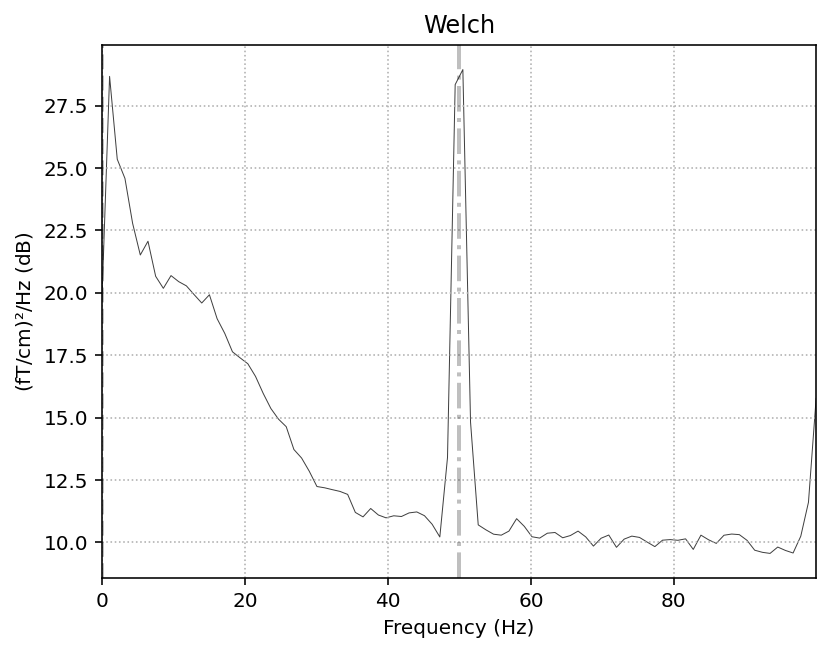
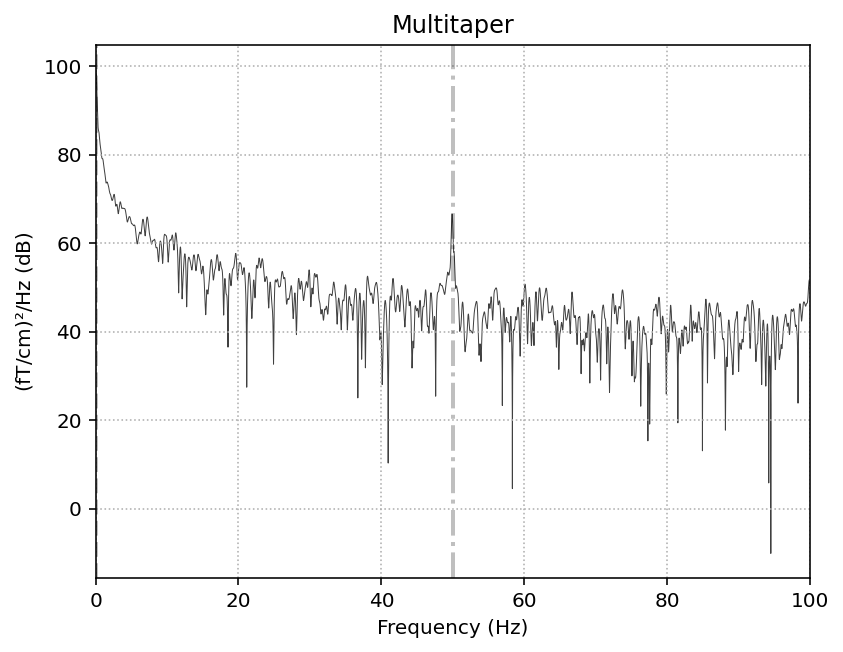

In [24]:
%matplotlib inline
mne.set_log_level('warning')

p1 = pn.bind(plot_welch_with_params, 
             raw=raw, 
             picks=channel_select, 
             f_range=freq_slider.param.value_throttled, 
             t_range=time_slider.param.value_throttled,
             n_fft=n_fft_input,
             n_overlap=n_overlap_input,
             window=window_select);
p2 = pn.bind(plot_taper_with_params, 
             raw=raw, 
             picks=channel_select, 
             f_range=freq_slider.param.value_throttled, 
             t_range=time_slider.param.value_throttled,
             normalization=normalization_select,
             bandwidth=bandwidth_input,
             low_bias=low_bias_select);

pn.Column(
    pn.Row('### PSD: Welch vs Multitaper'),
    pn.Row('**Common:**', channel_select, time_slider, freq_slider),
    pn.Row('**Welch:**', n_fft_input, n_overlap_input, window_select),
    pn.Row('**Multitaper:**', normalization_select, bandwidth_input, low_bias_select),
    pn.Row(pn.pane.Matplotlib(p1, tight=True),
           pn.pane.Matplotlib(p2, tight=True))
).servable()

**Exercise:**

1. Add Welch-specific parameters to the app:
 * `n_fft` - the size of data segments (in samples) used for FFT
 * `n_overlap` - the overlap of data segments (in samples)
 * `window` - the type of window applied to the data

2. Add multitaper-specific parameters to the app:
 * `normalization` - how the spectra values are normalized
 * `bandwidth` - average neighboring `bandwidth` frequency bins
 * `low_bias` - whether estimates (tapers) with high bias should be dropped